# Introduction to Naive Bayes

-----

In this notebook, we introduce the [naive Bayes classifier][sknb], which relates the probability an instance belongs to a given target class to the prior probability of each feature and the joint probability of the given set of features given the target class. By making an implicit assumption of conditional independence, this joint probability can be simplified into a product of individual conditional probabilities for each feature. By using this with Bayes theorem, we get the final probabilistic classification, given a set of features. This algorithm can be quick to apply, once the model is trained, and can often provide reasonable results, which can be used on its own, or as a comparative benchmark for more advanced techniques.

In this notebook, we first explore the probability concepts behind this classifier. Next, the naive Bayes classification algorithm is introduced by using the Iris data. Finally, the classifier is applied to a larger data set, the _German_ credit data set.

-----

[sknb]: http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

## Table of Contents

[Formalism](#Formalism)
- [Conditional Probability](#Conditional-Probability)
- [Naive Bayes](#Naive-Bayes)

[Naive Bayes: Classification](#Naive-Bayes:-Classification)

- [Naive Bayes: Decision Surface](#Naive-Bayes:-Decision-Surface)
- [Naive Bayes: Hyperparameters](#Naive-Bayes:-Hyperparameters)

[Classification: German Data](#Classification:-German-Data)

-----

Before proceeding with the Formalism section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

One of the simplest algorithms to apply to a data set is the [Naive Bayes][wnb] algorithm, which is based on the idea that a probabilistic relationship can be established between a given set of features, $\textrm{F}$, and the final classification, $\textrm{C}$. Or, mathematically, the probability of an instance being of class $\textrm{C}$ is dependent on the set of input features $\textrm{F}$: $\textrm{P(C | F)}$. For example, if we consider a subset of the features from the _tips_ data set, or just the `smoker` and `day` features, and we wish to classify the time of day when the meal was served, we have the following two possible probabilities: $\textrm{P(lunch | smoker, day)}$ and the $\textrm{P(dinner | smoker, day)}$.

In general, this relationship can be quite complex, as the different features may be related (e.g., the weather yesterday and the weather today). However, the naive Bayes algorithm makes a simplifying assumption that the individual features are independent given the target class. Thus, the complex relationship can be easily expressed as a product of the individual conditional probabilities for each feature. We can express this mathematically as follows. Given a set of features $f_i$, we express the full probability as the product:

$$ \textrm{P(F | C )} = \prod\limits_{i}\ \textrm{P( f}_{i}\textrm{ | C)}$$

The terms in the product are simply the conditional probabilities that, given the target class, a feature, $f_i$, has the specific value. Now, by Bayes theorem, we can express the desired probability, $\textrm{P( C | F)}$ in terms of these conditional probabilities:

$$
\textrm{P(C | F )} = \frac{\textrm{P(C)}\textrm{P(F | C )}}{\textrm{P(D)}}
$$

where $\textrm{P(F | C )}$ can be expanded using the previous product definition. Thus, in our earlier example, we have that $\textrm{P(lunch | smoker, day) = P(lunch | smoker) P(lunch | day)}$.

As a result, if we calculate the conditional probability that every feature has a specific value given a target class, we can calculate the probability our instance is the target class given its set of features. In general, the naive Bayes algorithm selects the class with the highest probability as the final classification. We expand on the definition (and calculation) of conditional probabilities in the next section, before applying this to compute a naive Bayes classification in the following section.

-----

[wnb]: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

[[Back to TOC]](#Table-of-Contents)

### Conditional Probability

We now explore the concept of conditional probability. To do this, we will use the _tips_ data set to compute frequency of occurrence of the categorical features: day and time, which have four and two options, respectively. To compute these frequencies, we need to determine the counts for each combination of parameters, as well as the total (or marginal) counts. The easiest technique to accomplish this is read the data in to a DataFrame and generate a pivot table with marginal counts.

The first Code cell below reads these data into a DataFrame and samples five rows at random to provide a quick check of the data. Since we have used these data repeatedly in other notebooks, we already know the data are clean and ready to analyze. We also add a special column that is set to one for every instance that will simplify generating the desired counts.

The second Code cell creates a pivot table from this new `data` column that has columns defined by the `day` and rows defined by the `time` categorical features. We also have counts computed for the entries in the pivot table by specifying `aggfunc='count'`, and we create cumulative total counts by specifying margins should be computed and displayed (`margins=True`).

-----

In [2]:
# Load Data Set
tdf = sns.load_dataset('tips')

# Add column on which to build pivot table
tdf['data']= 1

# Sample data
tdf.sample(5)

,total_bill,tip,sex,smoker,day,time,size,data
66,16.45,2.47,Female,No,Sat,Dinner,2,1
25,17.81,2.34,Male,No,Sat,Dinner,4,1
218,7.74,1.44,Male,Yes,Sat,Dinner,2,1
31,18.35,2.50,Male,No,Sat,Dinner,4,1
176,17.89,2.00,Male,Yes,Sun,Dinner,2,1


In [3]:
# Construct and display pivot table
pd.pivot_table(tdf, values='data', columns='day', index='time', 
               margins=True, fill_value=0, aggfunc='count')

day,Thur,Fri,Sat,Sun,All
time,,,,,
Lunch,61,7,0,0,68
Dinner,1,12,87,76,176
All,62,19,87,76,244


-----

From the counts presented in the _tips_ pivot table, we can determine the frequency of occurrence of a particular event. For example, the probability that a _Lunch_ is on a _Friday_ is given by the number of Friday lunches divided by the total number of lunches, or $7/68$.

At this point, we now have the information necessary to compute conditional probabilities, which lie at the heart of the naive Bayes algorithm. Recall that Bayes theorem relates one conditional probability  to another conditional probability:

$$
\textrm{P(A | B)} = \frac{\textrm{P(B | A)} \textrm{P(A)}}{\textrm{P(B)}}
$$

where $\textrm{P(A)}$ and $\textrm{P(B)}$ are the probabilities of observing the event $\textrm{A}$ and $\textrm{B}$ independently, and the $\textrm{P(B | A)}$ is the probability of observing event $B$ given that event $\textrm{A}$ occurred (or is true). This allows us to calculate $\textrm{P(A | B)}$, which is the conditional probability of event $\textrm{A}$ occurring, given that event $\textrm{B}$ occurred (or is true).

We can relate this to our _tips_ data by asking what is the conditional probability that an instance in the data is a _Lunch_, given that the event occurred on Friday? By Bayes theorem, we can express this conditional probability as:

$$\textrm{P(Lunch | Fri)} = \textrm{P(Fri | Lunch)} * \textrm{P(Lunch) } / \textrm{ P(Friday)}$$

From the pivot table results above, we can compute the individual probabilities:

$\textrm{P(Fri | Lunch)} = 7/68$  
$\textrm{P(Lunch)} = 68/244$  
$\textrm{P(Friday)} = 19/244$  

Thus, we can compute the desired conditional probability:

$\textrm{P(Lunch | Fri)} = (7/68) * (68/244) / (19/244) = (7/244)/(19/244) = 7/19 \approx 0.37$

This means that given a value of _Friday_ for the `day` feature, we would predict that the `time` is _Lunch_ with probability of $0.37$.

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding discussion, we computed the conditional probability $\textrm{P(Lunch | Friday)}$. Using the data from the _tips_ pivot table, try to compute the following probabilities.

1. $\textrm{P(Dinner)}$
3. $\textrm{P(Sun})$
4. $\textrm{P(Sat | Lunch})$

-----

[[Back to TOC]](#Table-of-Contents)

### Naive Bayes

To apply the naive Bayes algorithm we need to compute conditional probabilities. The key aspect of the naive Bayes algorithm is the assumption that these conditional probabilities are all independent. While this is rarely true in general, the assumption is often partially true, and the assumption can often enable quick and fairly accurate classifications to be made. 

As a specific example, suppose we wish to classify whether an instance in the _tips_ data set is a lunch or a dinner (i.e., a binary process). In the naive Bayes algorithm, this classification is determined by the individual conditional probabilities: $\textrm{P(Lunch | Thu)}$, $\textrm{P(Lunch | Fri)}$, $\textrm{P(Lunch | Sat)}$, and $\textrm{P(Lunch | Sun)}$. The independent assumption would be that the $\textrm{P(Lunch | Thu)}$ does not depend on $\textrm{P(Lunch | Fri)}$, which seems a reasonable assumption for this problem.

One approach to computing the conditional probabilities was demonstrated in the previous example. A problem with simply using the counts from a training data set, however, is that the entire process becomes completely _deterministic_, which means that the same result occurs every time we run the algorithm. In some cases this would not be a problem, but in general, we want to account for the fact that any data we have collected (or sampled) is merely a subset of the true _parent population_ that we wish to quantify. If we were to collect a second data set (or sample), we likely would produce a different training data set. 

To support this _sampling_ process, we can use our sampled data to compute the desired parameters of our relevant distribution. From this distribution, we can generate new samples (that are as large as we wish)  to compute the conditional probabilities required for the application of the naive Bayes algorithm. Now the problem becomes choosing a relevant probability distribution. In general, three distributions are commonly used:
- Bernoulli, for discrete, binary options (such as lunch or dinner). 
- Multinomial, for discrete, multiple, mutually exclusive options (such as Thursday, Friday, Saturday, or Sunday).
- Gaussian, for continuous distribution that are approximately normally distributed.

The following Code cell compares a conditional probability computed form the counts, as done earlier, with the results from different size samples from the Binomial distribution. In this case, we define the probability of occurrence (in this case for _Lunch) from the data. As the sample size increases, the sampled probability approaches the probability computed from the counts (as expected). However, a degree of randomness still remains, making this a more robust technique for computing conditional probabilities for use in the naive Bayes algorithm

-----

In [4]:
# Compute conditional probabilities as binomial process

# Set random seed for reproducabilty
rng = np.random.RandomState(23)

# Sample sizes of interest
sizes = [10, 100, 1000, 10000]

# The conditional probability
prob = 7/68

# Loop over different sample sizes
for size in sizes:
    print(f'{size} random data points.')
    # Generate random sequence
    seq = rng.binomial(1, prob, size)
    print(f'  Probability from random data = {np.sum(seq)/size:4.3f}')
    print(f'  Probability from data        = {prob:4.3f}\n')

10 random data points.
  Probability from random data = 0.100
  Probability from data        = 0.103

100 random data points.
  Probability from random data = 0.090
  Probability from data        = 0.103

1000 random data points.
  Probability from random data = 0.100
  Probability from data        = 0.103

10000 random data points.
  Probability from random data = 0.105
  Probability from data        = 0.103



-----

[[Back to TOC]](#Table-of-Contents)

## Naive Bayes: Classification

When applying the naive Bayes algorithm, we must choose a specific classifier that assumes the features are sampled from one of the three distributions presented earlier. This has one major drawback, if the set of features available can be broken into categories that each follow different distributions, we would need to apply different classifiers to the different sets of features. Thus, naive Bayes is generally only used in specific context, such as text classification, where it can quickly and easily be applied since the features are all of the same type. For example, in the text case, we generally assume these features follow a Multinomial distribution.

In the scikit learn library, we can employ the naive Bayes algorithm by creating one of three estimators, which are all in the `naive_bayes` module:

- [Gaussian Naive Bayes][gnb]: the features are assumed to  follow a normal distribution.
- [Multinomial Naive Bayes][mnb]: the features are assumed to follow a multinomial distribution.
- [Bernoulli Naive Bayes][bnb]: the features are assumed to follow a binomial distribution.

In this notebook, we use two different data sets to demonstrate naive Bayes classification, the first will assume the features follow a normal distribution (the Iris data), while the second will assume the data follow a multinomial distribution (the German data). 

The implementations of these estimators in the scikit learn do not accept many hyperparameters. The Gaussian naive Bayes estimator takes one hyperparameter: `priors`, which are the prior probabilities of the different classes. The Multinomial naive Bayes estimator takes three hyperparameters: `alpha`, a smoothing parameter, `fit_prior`, to indicate if the prior should be learned from the data, and `class_prior` to specify the class prior probabilities. Finally, the Binomial naive Bayes estimator takes four hyperparameters. The first three are the same as the Multinomial naive Bayes estimator, and the fourth is `binarize`, which provides a threshold to map features into binary vectors (since the Binomial algorithm assumes binary choices).

-----
[gnb]: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
[mnb]: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
[bnb]: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html




[[Back to TOC]](#Table-of-Contents)

### Classification: Iris Data

For our first demonstration of the naive Bayes algorithm, we first scale the data to make the features normalized, and generate training and testing samples. The following Code cell uses the `get_iris_data` function to perform these tasks, using a 60% set of data for training and 40% for testing. The result of the following Code cell is a visualization of the training data, along with ten test data points.

-----

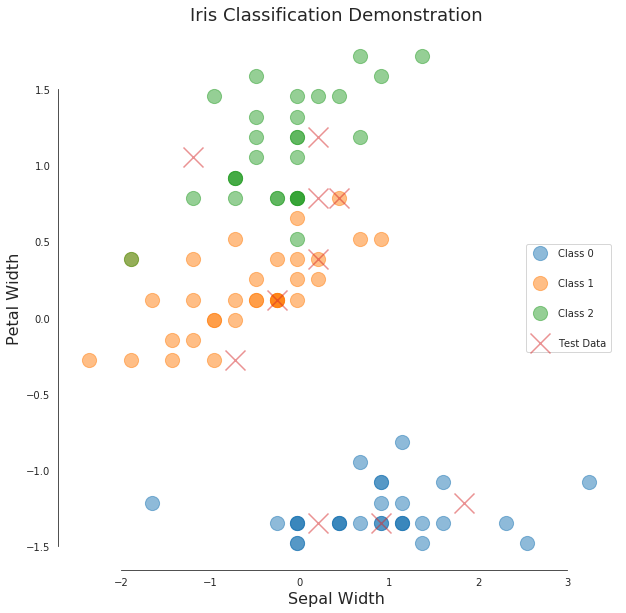

In [5]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.4

# Show the 'Train' and 'Test' data plot.
show_plot = True

# Split data into training and testing
# Note that we have both 'data' and 'labels'
d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)

-----

With these data loaded, scaled, and divided into training and testing sets, we can now analyze them. First, we create our `GaussianNB` classifier, which is appropriate since these data are continuous and have been normalized to have zero mean and unit standard deviation (in the helper function). We provide no hyperparameters, and accept the default values (which is only the `priors`  hyperparameter). Since we did not specify this, the prior probabilities (of the features) will be computed from the data. 

Next, the algorithm is fit to the training data, and a simple classification score is generated. In this simple example, the naive Bayes is competitive with the other algorithms we demonstrated. The second Code cell computes and displays a classification report, while the third Code cell computes and displays a confusion matrix. These demonstrate that the algorithm only struggles with several _Versicolor_, and _Virginica_ instances.

-----

In [6]:
# Next lets try Decision Trees
from sklearn.naive_bayes import GaussianNB

nbc = GaussianNB()

# Fit estimator to scaled training data
nbc = nbc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * nbc.score(d_test_sc, l_test)
print(f"Gaussian Naive Bayes accuracy = {score:5.1f}%")

Gaussian Naive Bayes accuracy =  93.3%


In [7]:
from sklearn.metrics import classification_report

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = nbc.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.85      0.94      0.89        18
   Virginica       0.95      0.86      0.90        21

   micro avg       0.93      0.93      0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



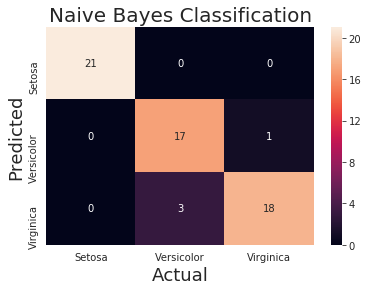

In [8]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             y_pred, labels, 3, 
             'Naive Bayes Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Naive Bayes:  Decision Surface

We now compute and display the decision surface for the naive Bayes classifier on the Iris data. In the following Code cell, we first trim our four-dimensional data set to two features: Sepal Width and Petal Width. Next, we create a mesh (or grid of points in two-dimensions) that spans these features. Next, we fit a naive Bayes classifier to the training data in these two dimensions, before applying this model to the test data and the two-dimensional mesh. The resulting figure shows the non-linear nature of this classifier, especially when using the `GaussianNB` estimator.

-----

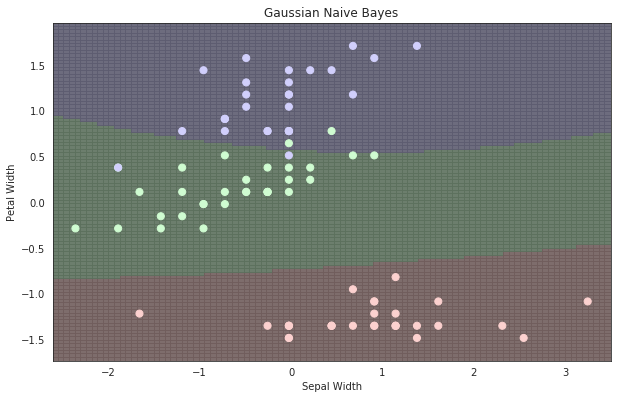

In [9]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
nbc.fit(n_data[:,:2], n_data[:,2])
    
# Predict for mesh grid
z = nbc.predict(mdata)
    
# Plot training data and mesh grid
hi.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)
    
ax.set_title(f'Gaussian Naive Bayes') ;

-----

[[Back to TOC]](#Table-of-Contents)

### Naive Bayes: Hyperparameters

Each of the three [naive Bayes estimators][sknb] in the scikit learn library have their own, small list of hyperparameters. Most of these were presented earlier in this notebook; the full set is available from each estimator's online documentation. To demonstrate the impact of a specific hyperparameter on the application of one of these estimators, we change classification estimators and use the `MultinomialNB` estimator on the Iris data. 

Granted this is not the best application for this estimator, which expects a set of discrete features. For the demonstration of the impact of this hyperparameter, we can proceed with the previous caution. In this case, we will change the `alpha` hyperparameter, which is an additive smoothing parameter that will remove fluctuations in smaller training data sets (where sampling noise might bias results). To demonstrate how this one hyperparameter impacts the performance of this classifier, we construct and compare decisions surfaces for different values of this one hyperparameter.

In the following Code call, we generate three different decision surfaces, corresponding to three different values of the `max_depth` hyperparameter: 0.0, 20.0, 50.0, where zero indicates no smoothing. As the following figures demonstrate, as the smoothing parameter increases, the area in the mesh grid assigned to the middle class widens, showing how the algorithm is smoothing over the training data in this reduced dimensional space. Of course, this classifier is not designed for data such as these (instead a set of categorical features would provide a better application domain. Decision surfaces are best created and displayed for continuous features).

----

[sknb]: http://scikit-learn.org/stable/modules/naive_bayes.html

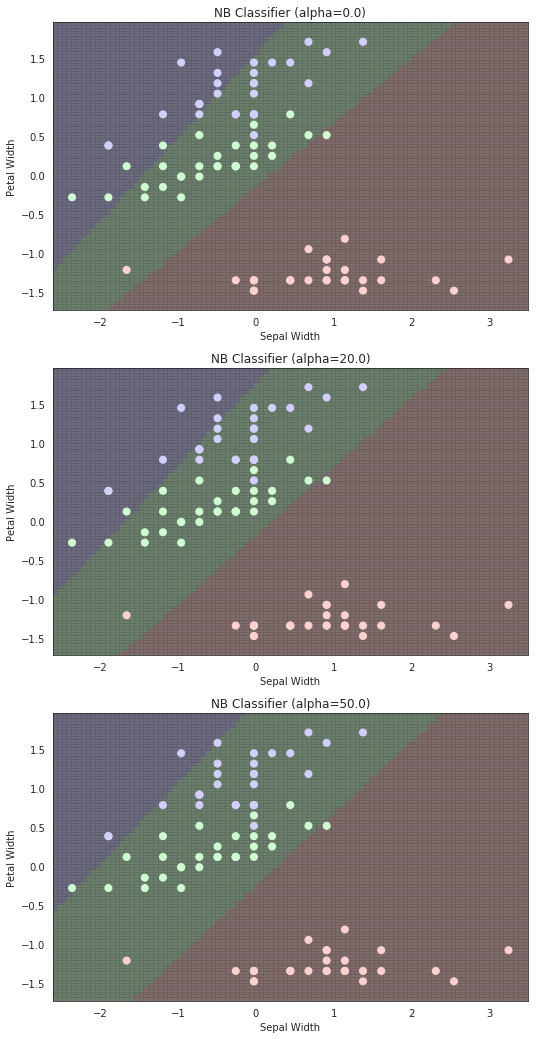

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
nbc = MultinomialNB()

alphas = [0.0, 20.0, 50.0]

# Show the mesh grid and training data
fig, axs = plt.subplots(figsize=(10,6 * len(alphas)), 
                        nrows=len(alphas), ncols=1, 
                        sharex=False)

# Make a two-dimensional Iris data set
# we include this line again here since shift
# the distribtuion to be positive-definite below
n_data = hi.trim_data(d_train_sc, l_train)

# Iterate through different neighbor counts
for idx, a in enumerate(alphas):
    
    # Now train our model
    nbc.set_params(alpha=a)
    
    # Add constant term to make all elements positive
    n_data[:,:2] += 2.5
    
    # MultinomialNB is a binary classifier
    # So we wrap it in the OneVsRestClassifier
    # to classify all three types of Iris    
    model = OneVsRestClassifier(nbc)
    
    # Now train our model
    model.fit(n_data[:,:2], n_data[:,2])
  
    # Predict for mesh grid
    z = model.predict(mdata)
    
    # Remove constant term to make all elements positive
    n_data[:,:2] -= 2.5  

    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'NB Classifier (alpha={a})')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used a simple Gaussian Naive Bayes model to predict classifications for the Iris Data. Now that you have run the Notebook once, go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change to a 75%:25%, and next, to a 50%:50%. How do the results change?
2. Change the `priors` hyperparameter in the Gaussian Naive Bayes algorithm to indicate arbitrary values (this is the expected prior probability of each class) in an array. Do the results change?

Finally, how does the decision surface for naive Bayes compare to the decision surface for a different classification algorithm such as k-nn, SVC, Logistic regression, or decision trees?

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: German Data

We now transition to a more complex data set on which to demonstrate the naive Bayes algorithm. One point to keep in mind is that the naive Bayes estimators make certain expectations of the features. Thus, the Gaussian naive Bayes expects continuous features that are normally distributed, while the Multinomial naive Bayes expects discrete features. Thus, it can be difficult to mix these types of features in a naive Bayes estimator.

As a result, we will use the [_German_ credit data][ucigd] set from the UCI machine learning repository. These data are fully documented online at the UCI website, and are appropriate for a demonstration since they contain a number of categorical features. The following two Code cells first define the local filename where we wish to store these data, and if the file does not yet exist, uses the wget command to grab these data from the UCI repository.

-----
[ucigd]: http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29



In [11]:
# German credit data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/

# First we find our HOME directory
tmp = !echo $HOME

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/german.data'

In [12]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

These data are used to determine a binary classification of good or bad credit risks. The features are all categorical (or symbolic), and thus provide a great, discrete data set with which to demonstrate the naive Bayes algorithm. The following Code cell defines our feature columns by using information from the relevant UCI machine learning database entry. Next, the data are read from the local file into a DataFrame. We randomly sample five rows to enable a quick review of the features.

-----

In [13]:
# German data archived at UCI ML Repository

col_names = ['CheckingStatus', 'Duration', 'CreditHistory', 
             'Purpose', 'CreditAmount', 'Savings', 
             'EmploymentStatus',  'InstallmentRate', 'Personal', 
             'Others', 'Residence', 'Property', 'Age', 'OtherPlans',
             'Housing', 'NumberCredits', 'Job', 'Telephone', 
             'NumberDepends', 'ForeignWorker', 'Label']

# Read CSV data from URL return Pandas
german_data = pd.read_csv(data_file, delim_whitespace=True, 
                          index_col=False, names = col_names)

# Display random sample
german_data.sample(5)

,CheckingStatus,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentStatus,InstallmentRate,Personal,Others,...,Property,Age,OtherPlans,Housing,NumberCredits,Job,Telephone,NumberDepends,ForeignWorker,Label
966,A12,27,A34,A43,2520,A63,A73,4,A93,A101,...,A122,23,A143,A152,2,A172,1,A191,A201,2
31,A11,24,A32,A42,4020,A61,A73,2,A93,A101,...,A123,27,A142,A152,1,A173,1,A191,A201,1
503,A12,24,A34,A43,1216,A62,A72,4,A93,A101,...,A124,38,A141,A152,2,A173,2,A191,A201,2
739,A12,30,A30,A49,4280,A62,A73,4,A92,A101,...,A123,26,A143,A151,2,A172,1,A191,A201,2
231,A14,9,A32,A40,2507,A63,A75,2,A93,A101,...,A124,51,A143,A153,1,A172,1,A191,A201,1


-----

With this DataFrame, we can now create our label array and our feature array to use with a naive Bayes classifier. In this case, we can easily construct these arrays by using the `dmatrices` function in the patsy module. This function takes a functional relationship between target classification (in the `Label` column of our DataFrame) and the categorical features we wish to use in the classification algorithm (recall that we indicate a categorical feature when using patsy by wrapping the feature in parentheses and prefixing this with a capital `C`). 

Beyond providing a simple technique to construct these arrays, patsy also drops one categorical feature to prevent multi-collinearity in our final classification. The `dmatrices` function also adds an intercept by default, which often improves the classification performance. After the arrays are constructed, we randomly sample five instances from the feature array, `x`.

-----

In [14]:
import patsy as pts 

y, x = pts.dmatrices('Label ~ C(CheckingStatus) + C(CreditHistory) + ' +
                     'C(Savings) + C(Purpose) + C(NumberCredits) + ' + 
                     'C(EmploymentStatus) + C(Personal) + C(Others) + ' +
                     'C(Property) + C(Housing) + C(Job)',
                     data=german_data, return_type='dataframe')

x.sample(5)

,Intercept,C(CheckingStatus)[T.A12],C(CheckingStatus)[T.A13],C(CheckingStatus)[T.A14],C(CreditHistory)[T.A31],C(CreditHistory)[T.A32],C(CreditHistory)[T.A33],C(CreditHistory)[T.A34],C(Savings)[T.A62],C(Savings)[T.A63],...,C(Others)[T.A102],C(Others)[T.A103],C(Property)[T.A122],C(Property)[T.A123],C(Property)[T.A124],C(Housing)[T.A152],C(Housing)[T.A153],C(Job)[T.A172],C(Job)[T.A173],C(Job)[T.A174]
254,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
817,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
142,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
438,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


-----

With our label and feature arrays constructed, we can now apply the relevant naive Bayes estimator from the scikit learn library. In this case, we have a set of features that are all discrete. For simplicity, we will apply the Multinomial naive Bayes classifier (although the encoding of the categorical features by patsy into _dummy categories_ means that the Bernoulli naive Bayes classifier would also be appropriate, since the features are all either zero or one).

In the following Code cell, we create our `MultinomialNB` estimator, and specify the `fit_prior` hyperparameter as `True` to compute the prior class probabilities from the data themselves. Otherwise a uniform prior is assumed. This estimator is fit to the training data, and a performance score is computed from the test data. Naively (no pun intended), the resulting classifier performance seems reasonable at roughly 70% accurate.

-----

In [15]:
from sklearn.model_selection import train_test_split

frac = 0.4

# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

from sklearn.naive_bayes import MultinomialNB

# Create Regressor with default properties
german_model = MultinomialNB(fit_prior=True)

# Fit estimator and display score
german_model = german_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(german_model.score(ind_test, dep_test)))

Score = 70.2%


-----

To understand the relative performance of our initial application of the multinomial naive Bayes classifier to these data, we can compute the _zero model_ performance, where we simply always predict the dominant class. In this example, we have many more _Good_ credit examples (`Label=1`) than _Bad_ credit examples (`Label=2`). Thus, the zero model would predict everyone as good credit risks, with performance almost identical to our initial multinomial naive Bays classifier.
 
-----

In [16]:
num_neg = np.sum(dep_test.Label==1)
num_pos = np.sum(dep_test.Label==2)
print(f'{num_neg:d} Good Credit')
print(f'{num_pos:d} Bad Credit')

zm = num_neg / (num_neg + num_pos)

print(f'Zero Model Performance = {100.0 * zm:4.2f}%')

282 Good Credit
118 Bad Credit
Zero Model Performance = 70.50%


-----

At first glance, this seems to indicate that our naive Bayes classifier is performing poorly. However, if we think more deeply about the problem, it is often the case that the relative cost of a misclassification is not equal. For example, if a bank denies someone a loan because they were misclassified as a bad risk, they potentially lose a customer. On the other hand, if a bank gives someone a loan because they were misclassified as a good risk, they potentially lose the money lent.

In this example, it is clear that the **cost** of a misclassification is imbalanced. In this case, we strongly prefer to misclassify a good risk as a bad risk, to minimize financial loses, than the other way around. To examine our initial naive Bayes classifier in more detail, the following two Code cells compute and display the classification report and the confusion matrix. From these, we see that we have many fewer misclassifications of bad to good than the zero model (which simply predicted everyone good). Thus, even this simple model provides reasonable performance for this task.

-----

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Classify test data and display score and report
predicted = german_model.predict(ind_test)
score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Multinomial NB Classification [German Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    classification_report(dep_test, predicted)))

Multinomial NB Classification [German Data] Score = 70.2%

Classification Report:
               precision    recall  f1-score   support

         1.0       0.75      0.87      0.80       282
         2.0       0.49      0.31      0.38       118

   micro avg       0.70      0.70      0.70       400
   macro avg       0.62      0.59      0.59       400
weighted avg       0.67      0.70      0.68       400




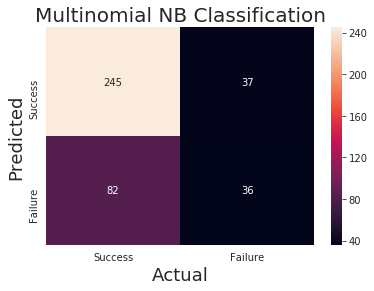

In [18]:
from helper_code import mlplots as ml

labels = ['Success', 'Failure']

# Call confusion matrix plotting routine
ml.confusion(dep_test.Label, 
             predicted, labels, 2, 
             'Multinomial NB Classification')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the multinomial naive Bayes classifier to model the German credit data example. Our initial approach provided reasonable results, but try the following changes to see if you can do better.

1. Change the classification algorithm to `BernoulliNB`.
3. Try using different hyperparameters. For example, try using different values of the smoothing hyperparameter `alpha`, or try specifying the `class_prior` hyperparameter to strongly deemphasize misclassifying bad risks as good (i.e., increase the class prior probability of the bad risks).

-----


## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. An [article][1] on applying the Gaussian Naive Bayes classifier in Python
1. An [article][2] discussing naive Bayes classification that uses the _Lego Movie_ as a motivating example

2. An [article][3] on the naive Bayes algorithm from the Analytics Vidyha website

55. This [stackoverflow][4] question and answer webpage provides a nice discussion on the foundation of the naive Bayes classification algorithm.

-----

[1]: https://medium.com/@gp_pulipaka/applying-gaussian-naïve-bayes-classifier-in-python-part-one-9f82aa8d9ec4
[2]: http://blog.yhat.com/posts/naive-bayes-in-python.html

[3]: https://www.analyticsvidhya.com/blog/2015/09/naive-bayes-explained/

[4]: https://stackoverflow.com/questions/10059594/a-simple-explanation-of-naive-bayes-classification

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode